# Задание 1. Метрические алгоритмы классификации
## Задание по курсу "Парктикум на ЭВМ"
Михеев Борис, 317 группа

In [1]:
import numpy as np
import time
from nearest_neighbors import *
from distances import *
from cross_validation import *
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
%matplotlib inline

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving mnist_784.csv to mnist_784.csv


Загрузим датасет, разобьем на обучающую и тестовую выборку:

In [3]:
data = pd.read_csv('mnist_784.csv')
X_train = data.iloc[:60000, :]
y_train = X_train.pop('class')
X_test = data.iloc[60000:, :]
y_test = X_test.pop('class')
target = data.pop('class')

Сравним время работы различных алгоритмов. Будем искать 5 ближайших соседей для каждого обьекта тестовой выборки, расстояние будем считать по случайно выбранным подмножествам признаков размеров 10, 20, 100 по евклидовой метрике 

In [23]:
feature_set = [(X_train.sample(i, axis=1).columns, i) for i in [10, 20, 100]]
strategy_set = ['my_own', 'brute', 'kd_tree', 'ball_tree']
for strategy in strategy_set:
    print(f'{strategy} strategy:')
    print('')
    for fset, size in feature_set:
        features = list(fset)
        fset_show = False
        if not fset_show:
            print(f'feature subset: {features}')
            fset_show = True
        print(f'size: {size}')
        clf = KNNClassifier(5, strategy, 'euclidean', False, 1000)
        start = time.time()
        res = clf.fit(X_train.loc[:, features].values, y_train.values)
        clf.find_kneighbors(X_test.loc[:, features].values, False)
        stop = time.time() - start
        print(f'time: {stop}')
        print('')

my_own strategy:

feature subset: ['pixel71', 'pixel13', 'pixel375', 'pixel410', 'pixel267', 'pixel379', 'pixel269', 'pixel583', 'pixel382', 'pixel194']
size: 10
time: 76.11378812789917

feature subset: ['pixel30', 'pixel597', 'pixel631', 'pixel488', 'pixel723', 'pixel409', 'pixel635', 'pixel745', 'pixel620', 'pixel58', 'pixel691', 'pixel703', 'pixel205', 'pixel52', 'pixel772', 'pixel521', 'pixel776', 'pixel429', 'pixel261', 'pixel161']
size: 20
time: 82.52883982658386

feature subset: ['pixel251', 'pixel59', 'pixel10', 'pixel712', 'pixel717', 'pixel266', 'pixel763', 'pixel15', 'pixel115', 'pixel56', 'pixel486', 'pixel127', 'pixel428', 'pixel129', 'pixel71', 'pixel210', 'pixel465', 'pixel23', 'pixel661', 'pixel275', 'pixel764', 'pixel297', 'pixel468', 'pixel172', 'pixel400', 'pixel554', 'pixel305', 'pixel132', 'pixel684', 'pixel411', 'pixel773', 'pixel253', 'pixel484', 'pixel451', 'pixel232', 'pixel669', 'pixel725', 'pixel49', 'pixel430', 'pixel371', 'pixel586', 'pixel709', 'pixel559',

Время работы стратегии my_own растет с ростом числа признаков. Стратегия brute работает за примерно одинаковое время, оно растет незначительно. Стратегия kd_tree при малом числе признаков работает несколько быстрее ball_tree, далее с ростом числа признаков разница во времени их работы становится более заметной, стретегия kd_tree оказывается быстрее. В целом самой вычислительно неэффективной является стратегия my_own. kd_tree и ball_tree являются самыми быстрыми при малом числе признаков, далее они работают дольше остальных стратегий.

Далее будем использовать стратегию brute как наиболее оптимальную.

Оценим по кросс-валидации с 3 фолдами точность и время работы алгоритма в зависимости от значения k и используемой метрики

In [24]:
k_set = np.arange(1, 11).astype('int64')
metrics_set = ['euclidean', 'cosine']
cv = kfold(X_train.shape[0], 3)
accuracies = {}
print('brute strategy:')
print('')
for metric in metrics_set:
    params = {
        'strategy':'brute',
        'metric':metric,
        'weights':False,
        'test_block_size':1000
    }
    start = time.time()
    res = knn_cross_val_score(X_train.values, y_train.values, k_set, 'accuracy', cv, **params)
    stop = time.time() - start
    print(f'time: {stop}')
    accuracies[metric] = res
    print('accuracy for k:')
    #print(res)
    for key in res:
        print(f'k={key}: {res[key]}')
    print('average accuracy:')
    for idx, val in enumerate([row.mean() for row in accuracies[metric].values()]):
        print(f'k={idx + 1}: {val}')
    print('')

brute strategy:

time: 188.85283374786377
accuracy for k:
k=1: [0.96895 0.96675 0.9667 ]
k=2: [0.9603  0.95995 0.96125]
k=3: [0.96955 0.96825 0.96715]
k=4: [0.96705 0.9667  0.9671 ]
k=5: [0.9681 0.9673 0.9672]
k=6: [0.96555 0.96495 0.9657 ]
k=7: [0.9652 0.965  0.9656]
k=8: [0.96415 0.9639  0.96525]
k=9: [0.9637  0.9632  0.96455]
k=10: [0.96245 0.9622  0.9637 ]
average accuracy:
k=0: 0.9674666666666667
k=1: 0.9605
k=2: 0.9683166666666668
k=3: 0.9669499999999999
k=4: 0.9675333333333334
k=5: 0.9653999999999999
k=6: 0.9652666666666666
k=7: 0.9644333333333334
k=8: 0.9638166666666667
k=9: 0.9627833333333333

time: 192.81404781341553
accuracy for k:
k=1: [0.9733  0.9708  0.97045]
k=2: [0.96895 0.9664  0.96775]
k=3: [0.97365 0.97155 0.9709 ]
k=4: [0.9725  0.97095 0.9722 ]
k=5: [0.97275 0.97015 0.9716 ]
k=6: [0.97195 0.9697  0.97215]
k=7: [0.97125 0.96815 0.97075]
k=8: [0.97125 0.96835 0.97155]
k=9: [0.97005 0.967   0.9707 ]
k=10: [0.96935 0.96615 0.9707 ]
average accuracy:
k=0: 0.9715166666666

Наилучшие значения достигаются при k=3. При использовании косинусной меры расстояния (cosine) значения accuracy несколько выше. Быстрее всего алгоритм работает для евклидовой метрики, несколько дольше для косинусной.

Рассмотрим взвешенный метод k ближайших соседей и сравним с методом без весов при одних и тех же остальных параметрах.

In [26]:
k_set = np.arange(1, 11).astype('int64')
metrics_set = ['euclidean', 'cosine']
cv = kfold(X_train.shape[0], 3)
accuracies = {}
accuracies['no_weights'] = {}
accuracies['with_weights'] = {}
print('brute strategy:')
print('')
for metric in metrics_set:
    print(f'{metric} metric:')
    print('')
    params = {
        'strategy':'brute',
        'metric':metric,
        'weights':False,
        'test_block_size':1000
    }
    start = time.time()
    res = knn_cross_val_score(X_train.values, y_train.values, k_set, 'accuracy', cv, **params)
    stop = time.time() - start
    print('without weights:')
    print('')
    print(f'time: {stop}')
    accuracies['no_weights'][metric] = res
    print('accuracy for k:')
    for key in res:
        print(f'k={key}: {res[key]}')
    print('average accuracy:')
    for idx, val in enumerate([row.mean() for row in accuracies['no_weights'][metric].values()]):
        print(f'k={idx}: {val}')
    print('')
    params['weights'] = True
    start = time.time()
    res = knn_cross_val_score(X_train.values, y_train.values.astype('int64'), k_set, 'accuracy', cv, **params)
    stop = time.time() - start
    print('with weights:')
    print('')
    print(f'time: {stop}')
    accuracies['with_weights'][metric] = res
    print('accuracy for k:')
    for key in res:
        print(f'k={key}: {res[key]}')
    print('average accuracy:')
    for idx, val in enumerate([row.mean() for row in accuracies['with_weights'][metric].values()]):
        print(f'k={idx}: {val}')
    print('')

brute strategy:

euclidean metric:

without weights:

time: 186.93339371681213
accuracy for k:
k=1: [0.96895 0.96675 0.9667 ]
k=2: [0.9603  0.95995 0.96125]
k=3: [0.96955 0.96825 0.96715]
k=4: [0.96705 0.9667  0.9671 ]
k=5: [0.9681 0.9673 0.9672]
k=6: [0.96555 0.96495 0.9657 ]
k=7: [0.9652 0.965  0.9656]
k=8: [0.96415 0.9639  0.96525]
k=9: [0.9637  0.9632  0.96455]
k=10: [0.96245 0.9622  0.9637 ]
average accuracy:
k=0: 0.9674666666666667
k=1: 0.9605
k=2: 0.9683166666666668
k=3: 0.9669499999999999
k=4: 0.9675333333333334
k=5: 0.9653999999999999
k=6: 0.9652666666666666
k=7: 0.9644333333333334
k=8: 0.9638166666666667
k=9: 0.9627833333333333

with weights:

time: 173.90227389335632
accuracy for k:
k=1: [0.96895 0.96675 0.9667 ]
k=2: [0.96895 0.96675 0.9667 ]
k=3: [0.97075 0.9691  0.96825]
k=4: [0.9713 0.9698 0.9701]
k=5: [0.96925 0.96825 0.96875]
k=6: [0.9704  0.96845 0.96945]
k=7: [0.96735 0.96595 0.967  ]
k=8: [0.9676  0.96665 0.9678 ]
k=9: [0.9651 0.9643 0.9657]
k=10: [0.9647  0.96465 0

Взвешенный knn дает лучшие показатели accuracy в сравнении с невзвешенным на тех же наборах параметров.

Применим лучший из алгоритмов:

In [16]:
params = {
        'strategy':'brute',
        'metric':'cosine',
        'weights':True,
        'test_block_size':1000
    }
clf = KNNClassifier(4, 'brute', 'cosine', True, 1000)
clf.fit(X_train.values, y_train.values)
print('on train data:')
start = time.time()
ans = clf.predict(X_train.values)
stop = time.time() - start
print(f'time: {stop}')
accuracy = (ans == y_train.values.astype('int64')).sum() / y_train.shape[0]
print(f'accuracy: {accuracy}')
print('on test data:')
start = time.time()
ans = clf.predict(X_test.values)
stop = time.time() - start
print(f'time: {stop}')
accuracy = (ans == y_test.values.astype('int64')).sum() / y_test.shape[0]
print(f'accuracy: {accuracy}')
cv = kfold(data.shape[0], 3)
res = knn_cross_val_score(data.values, target.values.astype('int64'), [4], 'accuracy', cv, **params)
cross_validation_score = [row.mean() for row in res.values()]
print(f'cross validation score: {cross_validation_score}')

on train data:
time: 272.97872829437256
accuracy: 1.0
on test data:
time: 44.62689256668091
accuracy: 0.9752
cross validation score: [0.9740857077126052]


Значение accuracy на тестовой выборке несколько выше, чем на кросс-валидации. 

Построим матрицу ошибок:

In [4]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    labels = np.unique(np.concatenate((y_true, y_pred), axis=0))
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(conf_matrix, cmap=plt.cm.Oranges)
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Истинный класс')
    ax.set_xlabel('Предсказанный класс')
    ax.set_label('Матрица ошибок')
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j])

    plt.savefig(fname='fig.pdf', format='pdf')


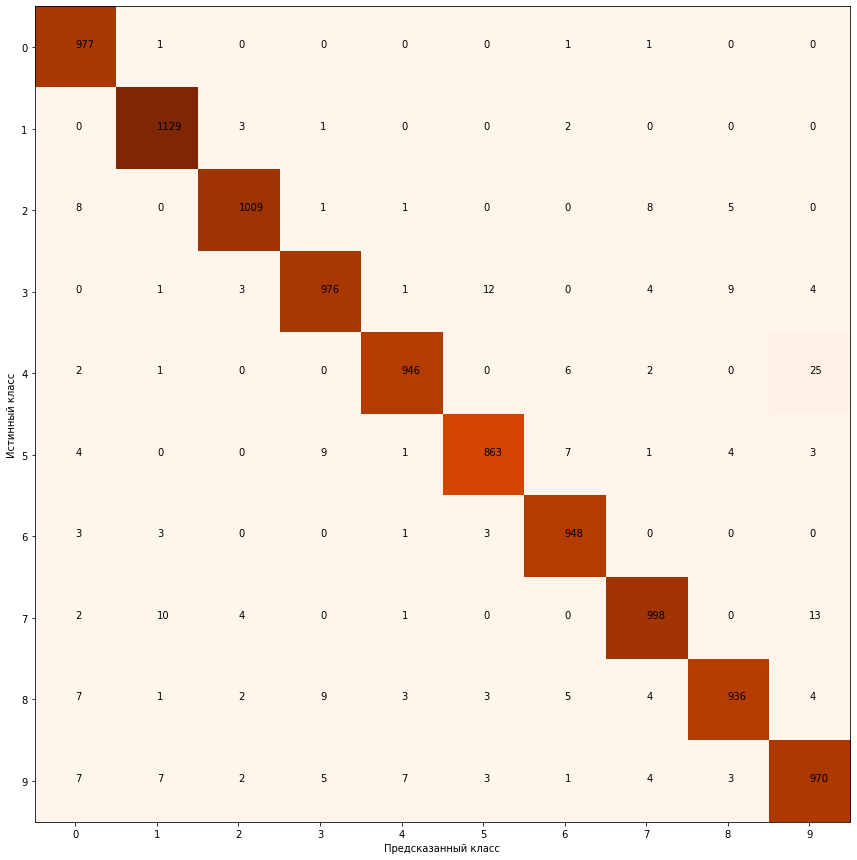

In [33]:
show_confusion_matrix(y_test.values.astype('int64'), ans)

Большинство объектов классифицировано верно, ложно классифицированных объектов мало, для каждого из классов количество неверных прогнозов незначительно по сравнению с размером самого класса. Это свидетельствует о хорошей точности алгоритма

Рассмотрим несколько неверно классифицированных объектов из тестовой выборки. Для этого найдем индексы объектов, на которых были допущены ошибки, визуализируем их. Ошибки могут быть допущены на объектах (рукописных цифрах), похожих друг на друга в зависимости от написания, например, 1 и 7, 2 и 7, 4 и 9, 7 и 9, 5 и 3 и т. д. Это можно заметить и по матрице ошибок

In [17]:
compare = (ans == y_test.values.astype('int64'))
wrong = []
for idx, correct in enumerate(compare):
    if not correct and y_test.values.astype('int64')[idx] == 7 and ans[idx] == 1:
        wrong.append(idx)

In [18]:
print(wrong)

[551, 1260, 1500, 2607, 3808, 3838, 3976, 4837, 4886, 4966]


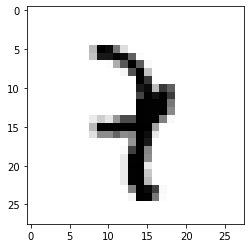

In [19]:
#Изображения в датасете MNIST имеют размер 28х28 пикселей
plt.imshow(X_test.iloc[wrong[0]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig71.pdf', format='pdf')

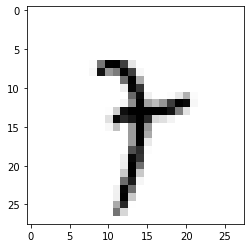

In [20]:
plt.imshow(X_test.iloc[wrong[-1]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig72.pdf', format='pdf')

In [21]:
wrong = []
for idx, correct in enumerate(compare):
    if not correct and y_test.values.astype('int64')[idx] == 7 and ans[idx] == 9:
        wrong.append(idx)

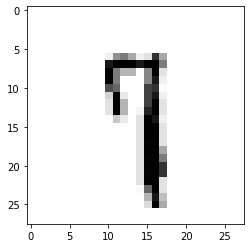

In [22]:
plt.imshow(X_test.iloc[wrong[0]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig73.pdf', format='pdf')

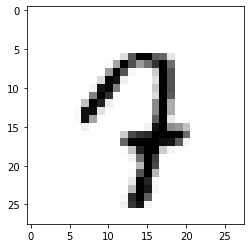

In [23]:
plt.imshow(X_test.iloc[wrong[-1]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig74.pdf', format='pdf')

In [24]:
wrong = []
for idx, correct in enumerate(compare):
    if not correct and y_test.values.astype('int64')[idx] == 5 and ans[idx] == 3:
        wrong.append(idx)

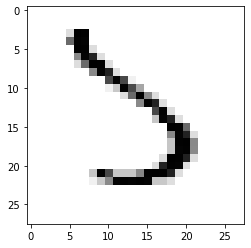

In [25]:
plt.imshow(X_test.iloc[wrong[0]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig51.pdf', format='pdf')

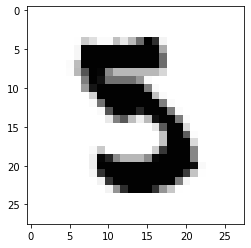

In [26]:
plt.imshow(X_test.iloc[wrong[-1]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig52.pdf', format='pdf')

In [27]:
wrong = []
for idx, correct in enumerate(compare):
    if not correct and y_test.values.astype('int64')[idx] == 4 and ans[idx] == 9:
        wrong.append(idx)

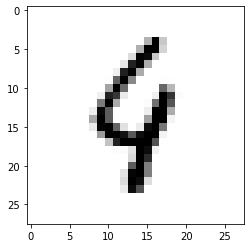

In [28]:
plt.imshow(X_test.iloc[wrong[0]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig41.pdf', format='pdf')

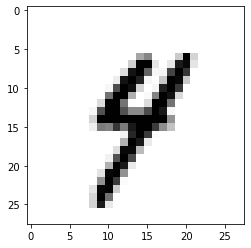

In [29]:
plt.imshow(X_test.iloc[wrong[-1]].values.reshape(28, 28), cmap='Greys')
plt.savefig(fname='fig42.pdf', format='pdf')

Соответствующие объекты действительно имеют схожие черты обоих видов соответствующих цифр

Размножим объекты обучающей выборки при помощи смещений, поворотов и использования гауссовского фильтра. Воспользуемся библиотекой skimage

In [5]:
from skimage.filters import gaussian
from skimage.transform import rotate
from skimage.transform import SimilarityTransform
from skimage.transform import warp

Для наглядности приведем некоторые примеры преобразований

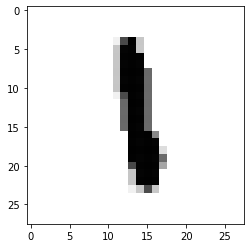

In [45]:
plt.imshow(X_train.iloc[200].values.reshape((28, 28)), cmap='Greys')

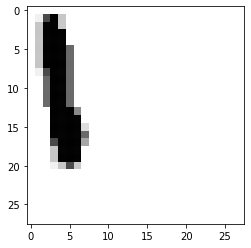

In [46]:
shifted = warp(X_train.iloc[200].values.reshape((28, 28)), SimilarityTransform(translation=(10,3)))
plt.imshow(shifted, cmap='Greys')

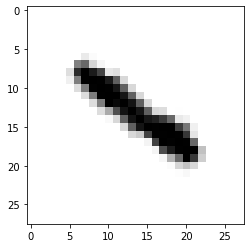

In [47]:
rotated = rotate(X_train.iloc[200].values.reshape((28, 28)), 45)
plt.imshow(rotated, cmap='Greys')

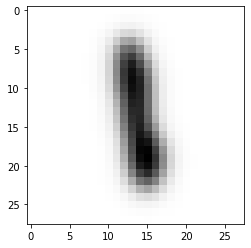

In [48]:
filtered = gaussian(X_train.iloc[200].values.reshape((28, 28)), sigma=1.5, preserve_range=True)
plt.imshow(filtered, cmap='Greys')

Рассмотрим различные комбинации преобразований изображений. Выберем случайно изображения из обучающей выборки, преобразуем их, добавим к исходной обучающей выборке и перемешаем их между собой

In [8]:
samples_idx = np.random.randint(X_train.shape[0], size=15000)
angles_set = [5, 10, 15, -5, -10, -15]
x_shifts_set = [1, 2, 3, -1, -2, -3]
y_shifts_set = [1, 2, 3, -1, -2, -3]
disps_set = [0.5, 1, 1.5]
accuracies = []
sets = []
import itertools
permutations_size = len(list(itertools.product(angles_set, x_shifts_set, y_shifts_set, disps_set)))
permutations_idx = np.random.randint(permutations_size, size=50)
shift_transform = np.vectorize(warp, signature='(n,m)->(n,m)', excluded=['inverse_map'])
rotate_transform = np.vectorize(rotate, signature='(n,m)->(n,m)', excluded=['angle'])
gauss_transform = np.vectorize(gaussian, signature='(n,m)->(n,m)', excluded=['sigma'])
for idx, param_set in enumerate(itertools.product(angles_set, x_shifts_set, y_shifts_set, disps_set)):
    if idx not in permutations_idx:
        continue
    source = X_train.iloc[samples_idx].copy(deep=True)
    processed = np.apply_along_axis(np.reshape, 1, source, (28, 28))
    shifted_pics = shift_transform(processed, inverse_map=SimilarityTransform(translation=(param_set[1], param_set[2]))).reshape((processed.shape[0], 28 * 28))
    rotated_pics = rotate_transform(processed, angle=param_set[0]).reshape((processed.shape[0], 28 * 28))
    filtered_pics = gauss_transform(processed, sigma=param_set[3]).reshape((processed.shape[0], 28 * 28))
    X_train_aug = np.concatenate((source.values, shifted_pics, rotated_pics, filtered_pics), axis=0)
    y_train_aug = np.concatenate((
        y_train.iloc[samples_idx].values, 
        y_train.iloc[samples_idx].values, 
        y_train.iloc[samples_idx].values, 
        y_train.iloc[samples_idx].values), 
        axis=0)
    shuffle_idx = np.random.permutation(X_train_aug.shape[0])
    cv = kfold(X_train_aug[shuffle_idx].shape[0], 3)
    params = {
        'strategy':'brute',
        'metric':'cosine',
        'weights':True,
        'test_block_size':1000
    }
    res = knn_cross_val_score(X_train_aug[shuffle_idx], y_train_aug[shuffle_idx].astype('int64'), [4], 'accuracy', cv, **params)
    accuracies.append(res[4].mean())
    sets.append(param_set)

for i in range(len(sets)):
    print(sets[i])
    print(accuracies[i])

print('')
print('best set:')
best_idx = np.argmax(accuracies)
print(sets[best_idx])
print('best accuracy:')
print(accuracies[best_idx])

(5, 1, -3, 0.5)
0.9882
(5, 2, 2, 0.5)
0.9886333333333334
(5, 2, -1, 1.5)
0.9800666666666666
(5, 3, -1, 1.5)
0.9805999999999999
(5, -2, -2, 1.5)
0.97955
(5, -3, 3, 1)
0.9869166666666667
(5, -3, -2, 0.5)
0.9888833333333333
(10, 2, -3, 1)
0.9815666666666667
(10, -1, 2, 1.5)
0.9772500000000001
(10, -1, -3, 1.5)
0.9761666666666667
(10, -2, -1, 0.5)
0.9850166666666667
(10, -2, -2, 1)
0.9817
(10, -3, 2, 1.5)
0.9767833333333332
(15, 1, -1, 0.5)
0.983
(15, 2, 1, 0.5)
0.9806166666666667
(15, 2, -1, 1.5)
0.9727833333333332
(15, 2, -2, 1)
0.9778500000000001
(15, 3, -1, 0.5)
0.9800999999999999
(15, -2, 1, 0.5)
0.9810833333333333
(15, -2, 3, 1.5)
0.9738000000000001
(15, -2, -2, 0.5)
0.9802166666666666
(15, -3, 2, 1)
0.9777333333333332
(15, -3, -1, 0.5)
0.9801333333333333
(-5, 3, 3, 1.5)
0.9801833333333333
(-5, -1, -1, 1.5)
0.9808
(-5, -1, -2, 0.5)
0.9879333333333333
(-5, -3, 1, 0.5)
0.9882333333333334
(-5, -3, -1, 1)
0.9871666666666666
(-5, -3, -2, 1)
0.9867666666666667
(-5, -3, -3, 1.5)
0.980683333

При применении аугментации обучающей выборки качество классификации выше, чем на исходных данных, даже при случайной выборке параметров преобразований и объектов выборки. Наилучшее значение accuracy=0.9884333333333334 достигается на наборе параметров (-5, -1, 2, 0.5)

Применим найденные параметры к алгоритму и проанализируем результат

In [11]:
best_set = (5, -1, 2, 0.5)
clf = KNNClassifier(4, 'brute', 'cosine', True, 1000)
source = X_train.copy(deep=True)
processed = np.apply_along_axis(np.reshape, 1, source, (28, 28))
shifted_pics = shift_transform(processed, inverse_map=SimilarityTransform(translation=(best_set[1], best_set[2]))).reshape((processed.shape[0], 28 * 28))
rotated_pics = rotate_transform(processed, angle=best_set[0]).reshape((processed.shape[0], 28 * 28))
filtered_pics = gauss_transform(processed, sigma=best_set[3]).reshape((processed.shape[0], 28 * 28))
X_train_aug = np.concatenate((source.values, shifted_pics, rotated_pics, filtered_pics), axis=0)
y_train_aug = np.concatenate((y_train.values, y_train.values, y_train.values, y_train.values), axis=0)
shuffle_idx = np.random.permutation(X_train_aug.shape[0])
clf.fit(X_train_aug[shuffle_idx], y_train_aug[shuffle_idx])
ans = clf.predict(X_test.values)
accuracy = (ans == y_test.values.astype('int64')).sum() / y_test.shape[0]
print(f'accuracy with train augmentation: {accuracy}')

accuracy with train augmentation: 0.9777


Точность классификации увеличилась. Проанализируем матрицу ошибок.

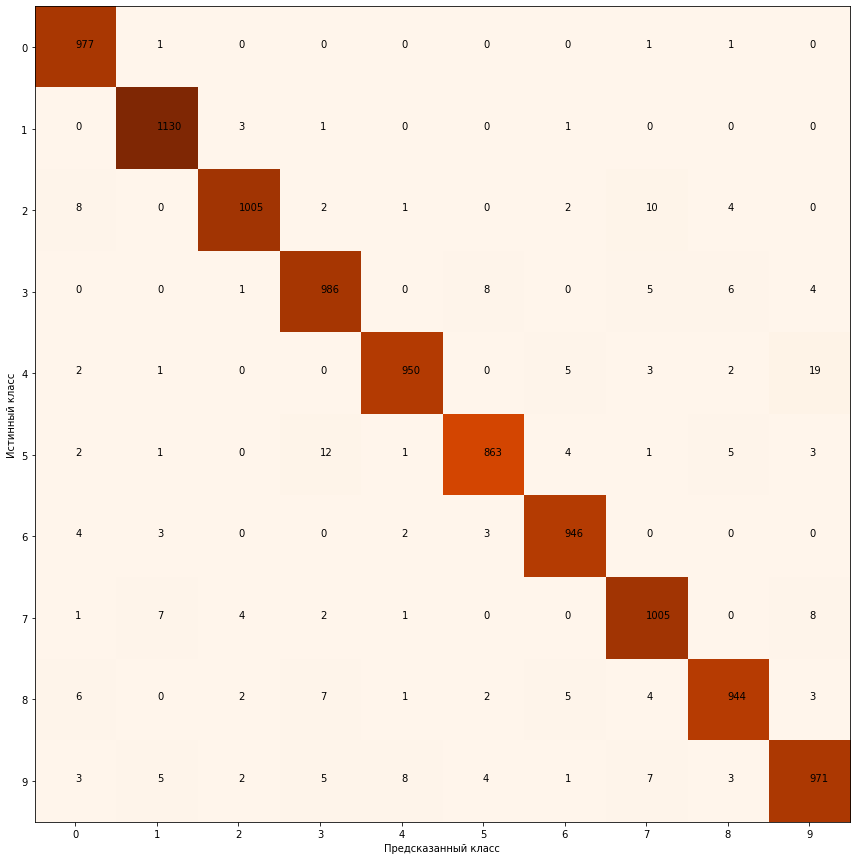

In [12]:
show_confusion_matrix(y_test.values.astype('int64'), ans)

Большинство объектов по прежнему классифицировано верно. Уменьшилось число ошибок на схожих цифрах.

Теперь применим преобразования к тестовой выборке при исходной обучающей выборке и рассмотрим результат работы алгоритма при тех же параметрах

In [13]:
clf = KNNClassifier(4, 'brute', 'cosine', True, 1000)
source = X_test.copy(deep=True)
processed = np.apply_along_axis(np.reshape, 1, source, (28, 28))
shifted_pics = shift_transform(processed, inverse_map=SimilarityTransform(translation=(best_set[1], best_set[2]))).reshape((processed.shape[0], 28 * 28))
rotated_pics = rotate_transform(processed, angle=best_set[0]).reshape((processed.shape[0], 28 * 28))
filtered_pics = gauss_transform(processed, sigma=best_set[3]).reshape((processed.shape[0], 28 * 28))
X_test_aug = np.concatenate((source.values, shifted_pics, rotated_pics, filtered_pics), axis=0)
y_test_aug = np.concatenate((y_test.values, y_test.values, y_test.values, y_test.values), axis=0)
clf.fit(X_train.values, y_train.values)
aug_ans = clf.predict(X_test_aug)
ans = np.zeros(10000)
for i in range(10000):
    vals, counts = np.unique([aug_ans[i], aug_ans[i + 10000], aug_ans[i + 20000], aug_ans[i + 30000]], return_counts=True)
    idx = np.argmax(counts)
    ans[i] = vals[idx]
accuracy = (ans == y_test.values.astype('int64')).sum() / y_test.shape[0]
print(f'accuracy with test augmentation: {accuracy}')

accuracy with test augmentation: 0.9755


Данное значение accuracy незначительно лучше точности на исходных данных, причиной чего может быть выбор оптимальных параметров аугментаций не из всего множества сочетаний и не на всей обучающей выборке. 

Рассмотрим матрицу ошибок:

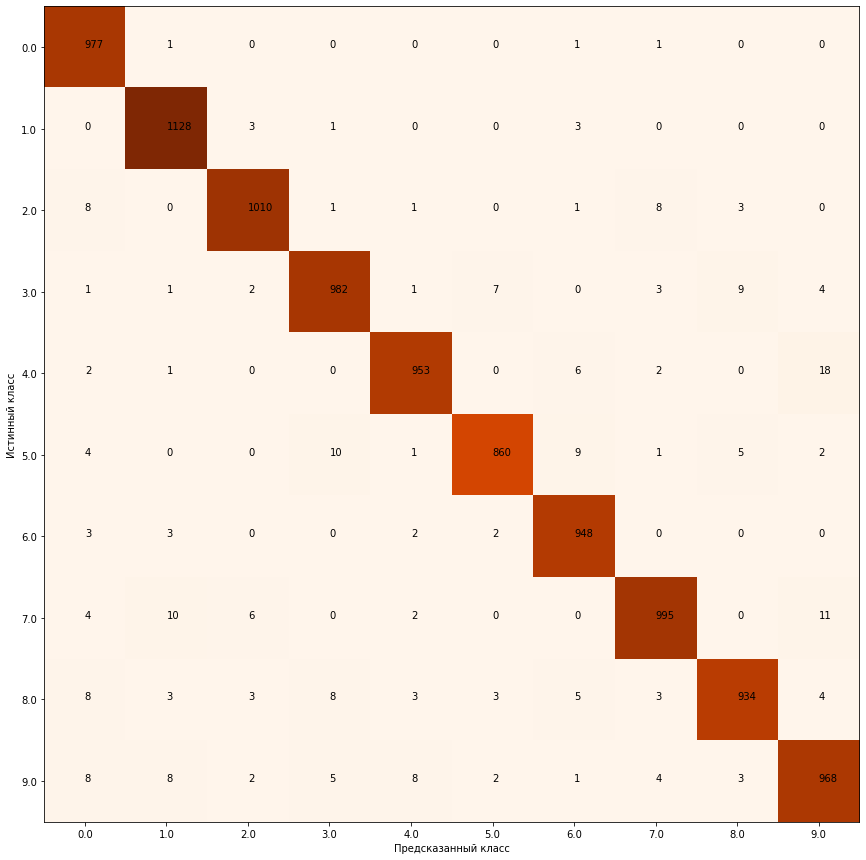

In [14]:
show_confusion_matrix(y_test.values.astype('int64'), ans)

В основном объекты все так же классифицированы верно, на схожих объектах допущено чуть меньше ошибок. Преобразование тренировочной выборки дало лучший результат, чем преобразование тестовой. Целесообразно использовать аугментации обеих выборок.